In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
 #for explainable
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

C:\Users\yosep\anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = 'edited/'
train_path = 'edited/train'
test_path = 'edited/test'
os.listdir(train_path)
     

['COVID19', 'NORMAL']

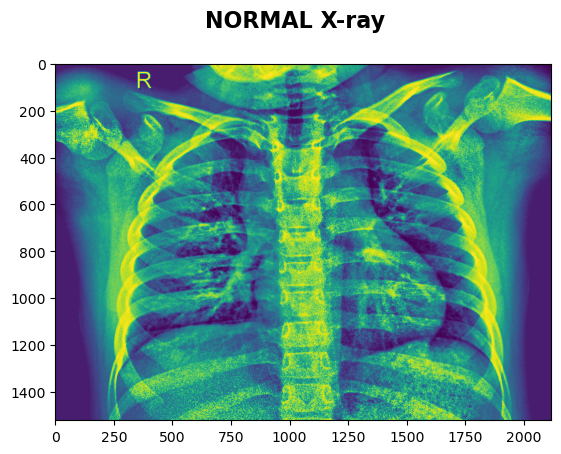

In [3]:

normal_sample = imread(train_path+"/NORMAL"+"/enhanced_NORMAL(285).jpg")
plt.imshow(normal_sample)
plt.suptitle('NORMAL X-ray', fontsize=16, weight='bold');

In [45]:
pwd


'C:\\Users\\yosep\\Music'

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True,
                                  vertical_flip= True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)
     

Found 1736 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [5]:
image_size = (224,224,3)

model_2 = Sequential()
model_2.add(Conv2D(64,(3,3),activation = "relu", input_shape = image_size))
model_2.add(MaxPool2D())

model_2.add(Conv2D( 128, (3,3), activation = "relu"))
model_2.add(MaxPool2D())
model_2.add(Dropout(0.2))

model_2.add(Conv2D( 256,(3,3), activation = "relu"))
model_2.add(MaxPool2D())
model_2.add(Dropout(0.2))

model_2.add(Conv2D( 512,(3,3), activation = "relu"))
model_2.add(MaxPool2D())
model_2.add(Dropout(0.2))


model_2.add(Flatten())
model_2.add(Dense(512, activation = "relu"))
model_2.add(Dropout(0.15))

model_2.add(Dense(2, activation = "softmax"))


model_2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_2.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 54, 54, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       2

In [6]:
from datetime import datetime
start=datetime.now()

history_2 = model_2.fit(training_set, validation_data=test_set,steps_per_epoch=54,epochs=50)

end=datetime.now()
print('training time:', end-start)

Epoch 1/50
54/54 [==============================] - 84s 1s/step - loss: 0.9759 - accuracy: 0.7101 - val_loss: 0.5688 - val_accuracy: 0.7321
Epoch 2/50
54/54 [==============================] - 52s 950ms/step - loss: 0.5701 - accuracy: 0.7359 - val_loss: 0.5353 - val_accuracy: 0.7321
Epoch 3/50
54/54 [==============================] - 54s 997ms/step - loss: 0.3785 - accuracy: 0.8163 - val_loss: 0.2362 - val_accuracy: 0.9076
Epoch 4/50
54/54 [==============================] - 50s 924ms/step - loss: 0.2366 - accuracy: 0.9067 - val_loss: 0.2027 - val_accuracy: 0.9030
Epoch 5/50
54/54 [==============================] - 53s 978ms/step - loss: 0.1950 - accuracy: 0.9231 - val_loss: 0.3618 - val_accuracy: 0.8360
Epoch 6/50
54/54 [==============================] - 57s 1s/step - loss: 0.1681 - accuracy: 0.9308 - val_loss: 0.0676 - val_accuracy: 0.9723
Epoch 7/50
54/54 [==============================] - 52s 961ms/step - loss: 0.1433 - accuracy: 0.9419 - val_loss: 0.1380 - val_accuracy: 0.9423
Epoch

In [8]:
print("training_accuracy", history_2.history['accuracy'][-1])
print("validation_accuracy", history_2.history['val_accuracy'][-1])

training_accuracy 0.987089216709137
validation_accuracy 0.9930716156959534


<AxesSubplot:>

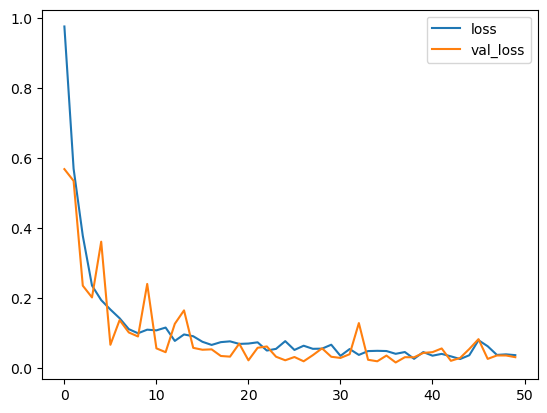

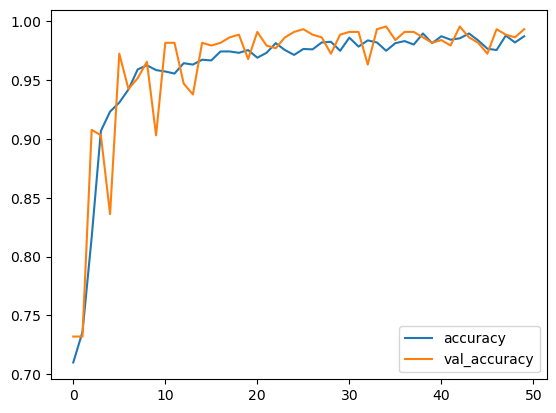

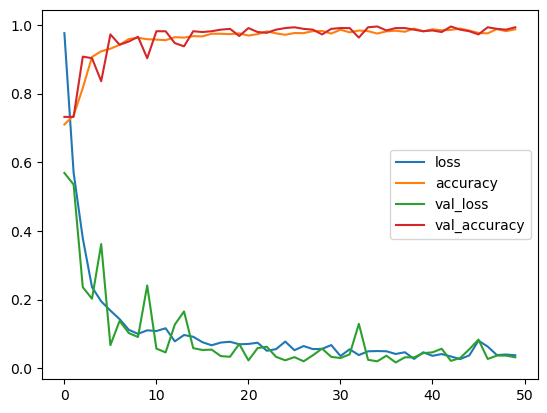

In [9]:
losses = pd.DataFrame(history_2.history)
losses.head()
losses[['loss','val_loss']].plot() 
losses[['accuracy','val_accuracy']].plot() 
losses.plot()

In [11]:
import os
model_version=max([int(i) for i in os.listdir("Saved_Models") + [0]])+1
model_2.save(f"Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: Saved_Models/2\assets


INFO:tensorflow:Assets written to: Saved_Models/2\assets


14/14 [==============================] - 8s 492ms/step


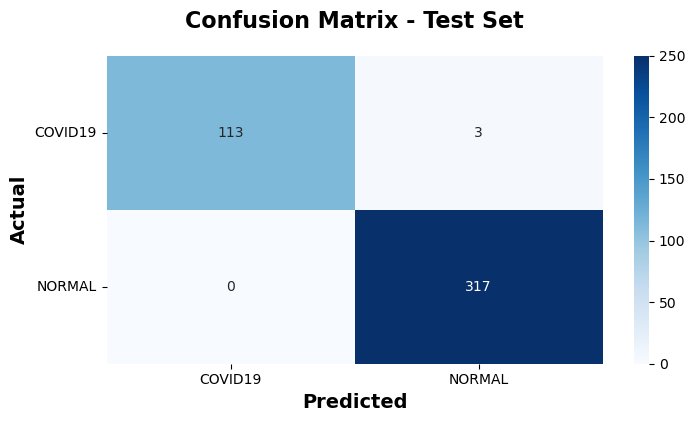

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL"]

y_pred = model_2.predict(test_set)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_set.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(8, 4))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [13]:
print(classification_report(y_true, predictions))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       116
           1       0.99      1.00      1.00       317

    accuracy                           0.99       433
   macro avg       1.00      0.99      0.99       433
weighted avg       0.99      0.99      0.99       433



In [14]:
class_dict = {0:'COVID19',
              1:'NORMAL'
              }

In [15]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class

In [16]:
def visualize(file_path,ax,text_loc):
    test_image = cv2.imread(data_path + file_path)
    test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model_2.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_dict[pred_class]
    
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model_2.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

1/1 [==============================] - 0s 16ms/step


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:10, 96.07it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:10, 97.88it/s]

1/1 [==============================] - 0s 12ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:09, 98.38it/s]

1/1 [==============================] - 0s 5ms/step


  4%|███▎                                                                           | 42/1000 [00:00<00:09, 105.71it/s]

1/1 [==============================] - 0s 19ms/step


  5%|████▏                                                                          | 53/1000 [00:00<00:08, 106.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|█████                                                                          | 64/1000 [00:00<00:08, 106.98it/s]

1/1 [==============================] - 0s 19ms/step


  8%|█████▉                                                                         | 75/1000 [00:00<00:08, 107.27it/s]

1/1 [==============================] - 0s 8ms/step


  9%|██████▊                                                                        | 86/1000 [00:00<00:08, 107.45it/s]

1/1 [==============================] - 0s 19ms/step


 10%|███████▋                                                                       | 97/1000 [00:00<00:08, 108.23it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▋                                                                      | 110/1000 [00:01<00:09, 92.04it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█████████▌                                                                     | 121/1000 [00:01<00:09, 96.27it/s]

1/1 [==============================] - 0s 19ms/step


 13%|██████████▎                                                                   | 133/1000 [00:01<00:08, 102.55it/s]

1/1 [==============================] - 0s 18ms/step


 14%|███████████▏                                                                  | 144/1000 [00:01<00:08, 103.63it/s]

1/1 [==============================] - 0s 22ms/step


 16%|████████████                                                                  | 155/1000 [00:01<00:08, 104.18it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█████████████                                                                 | 167/1000 [00:01<00:07, 108.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|██████████████▏                                                                | 180/1000 [00:01<00:08, 92.86it/s]

1/1 [==============================] - 0s 20ms/step


 19%|███████████████                                                                | 190/1000 [00:01<00:08, 94.17it/s]

1/1 [==============================] - 0s 19ms/step


 20%|███████████████▊                                                               | 200/1000 [00:01<00:08, 95.45it/s]

1/1 [==============================] - 0s 7ms/step


 21%|████████████████▌                                                             | 212/1000 [00:02<00:07, 101.72it/s]

1/1 [==============================] - 0s 20ms/step


 22%|█████████████████▍                                                            | 223/1000 [00:02<00:07, 103.24it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████▎                                                           | 234/1000 [00:02<00:07, 101.31it/s]

1/1 [==============================] - 0s 19ms/step


 24%|███████████████████                                                           | 245/1000 [00:02<00:07, 102.24it/s]

1/1 [==============================] - 0s 21ms/step


 26%|███████████████████▉                                                          | 256/1000 [00:02<00:07, 103.67it/s]

1/1 [==============================] - 0s 22ms/step


 27%|████████████████████▊                                                         | 267/1000 [00:02<00:07, 103.43it/s]

1/1 [==============================] - 0s 21ms/step


 28%|█████████████████████▋                                                        | 278/1000 [00:02<00:06, 104.76it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██████████████████████▌                                                       | 289/1000 [00:02<00:06, 106.17it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:03<00:08, 86.22it/s]

1/1 [==============================] - 0s 20ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:03<00:07, 89.46it/s]

1/1 [==============================] - 0s 19ms/step


 32%|█████████████████████████▎                                                     | 321/1000 [00:03<00:07, 94.77it/s]

1/1 [==============================] - 0s 16ms/step


 33%|██████████████████████████▏                                                    | 331/1000 [00:03<00:07, 95.35it/s]

1/1 [==============================] - 0s 3ms/step


 34%|██████████████████████████▊                                                   | 344/1000 [00:03<00:06, 104.58it/s]

1/1 [==============================] - 0s 18ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:03<00:06, 96.36it/s]

1/1 [==============================] - 0s 20ms/step


 37%|█████████████████████████████                                                 | 372/1000 [00:03<00:06, 102.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|█████████████████████████████▊                                                | 383/1000 [00:03<00:05, 103.55it/s]

1/1 [==============================] - 0s 14ms/step


 40%|██████████████████████████████▊                                               | 395/1000 [00:03<00:05, 107.49it/s]

1/1 [==============================] - 0s 19ms/step


 41%|███████████████████████████████▋                                              | 407/1000 [00:04<00:05, 110.17it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████████████████████████████████▋                                             | 419/1000 [00:04<00:05, 112.51it/s]

1/1 [==============================] - 0s 31ms/step


 43%|██████████████████████████████████                                             | 431/1000 [00:04<00:06, 92.60it/s]

1/1 [==============================] - 0s 7ms/step


 44%|██████████████████████████████████▉                                            | 443/1000 [00:04<00:05, 99.38it/s]

1/1 [==============================] - 0s 19ms/step


 45%|███████████████████████████████████▍                                          | 454/1000 [00:04<00:05, 102.15it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████████████████████████████████████▎                                         | 466/1000 [00:04<00:05, 106.46it/s]

1/1 [==============================] - 0s 20ms/step


 48%|█████████████████████████████████████▎                                        | 478/1000 [00:04<00:04, 109.66it/s]

1/1 [==============================] - 0s 16ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:04<00:05, 91.95it/s]

1/1 [==============================] - 0s 4ms/step


 50%|███████████████████████████████████████▌                                       | 501/1000 [00:04<00:05, 96.26it/s]

1/1 [==============================] - 0s 5ms/step


 51%|████████████████████████████████████████                                      | 513/1000 [00:05<00:04, 102.27it/s]

1/1 [==============================] - 0s 18ms/step


 52%|████████████████████████████████████████▊                                     | 524/1000 [00:05<00:04, 103.20it/s]

1/1 [==============================] - 0s 5ms/step


 54%|█████████████████████████████████████████▊                                    | 536/1000 [00:05<00:04, 107.62it/s]

1/1 [==============================] - 0s 9ms/step


 55%|██████████████████████████████████████████▋                                   | 548/1000 [00:05<00:04, 111.06it/s]

1/1 [==============================] - 0s 16ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:05<00:04, 92.56it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████████████████████████████████████████████                                  | 571/1000 [00:05<00:04, 96.82it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████████████████████████████████████████████▍                                | 583/1000 [00:05<00:04, 102.46it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▍                               | 595/1000 [00:05<00:03, 106.97it/s]

1/1 [==============================] - 0s 7ms/step


 61%|███████████████████████████████████████████████▎                              | 607/1000 [00:05<00:03, 109.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|████████████████████████████████████████████████▎                             | 619/1000 [00:06<00:03, 112.08it/s]

1/1 [==============================] - 0s 16ms/step


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [00:06<00:03, 92.29it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [00:06<00:03, 96.39it/s]

1/1 [==============================] - 0s 12ms/step


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [00:06<00:03, 99.84it/s]

1/1 [==============================] - 0s 19ms/step


 66%|███████████████████████████████████████████████████▊                          | 665/1000 [00:06<00:03, 105.30it/s]

1/1 [==============================] - 0s 20ms/step


 68%|████████████████████████████████████████████████████▋                         | 676/1000 [00:06<00:03, 106.61it/s]

1/1 [==============================] - 0s 20ms/step


 69%|█████████████████████████████████████████████████████▌                        | 687/1000 [00:06<00:02, 107.56it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:06<00:03, 92.90it/s]

1/1 [==============================] - 0s 16ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:07<00:03, 94.51it/s]

1/1 [==============================] - 0s 13ms/step


 72%|████████████████████████████████████████████████████████▎                     | 722/1000 [00:07<00:02, 101.11it/s]

1/1 [==============================] - 0s 15ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 733/1000 [00:07<00:02, 103.44it/s]

1/1 [==============================] - 0s 16ms/step


 74%|██████████████████████████████████████████████████████████                    | 745/1000 [00:07<00:02, 107.80it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████████████████████████████████████████████████████████                   | 757/1000 [00:07<00:02, 110.91it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 769/1000 [00:07<00:02, 112.52it/s]

1/1 [==============================] - 0s 16ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [00:07<00:02, 93.20it/s]

1/1 [==============================] - 0s 13ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 794/1000 [00:07<00:02, 102.03it/s]

1/1 [==============================] - 0s 19ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 805/1000 [00:07<00:01, 103.68it/s]

1/1 [==============================] - 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 816/1000 [00:08<00:01, 103.38it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 828/1000 [00:08<00:01, 107.97it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:08<00:01, 91.39it/s]

1/1 [==============================] - 0s 6ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [00:08<00:01, 98.44it/s]

1/1 [==============================] - 0s 18ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [00:08<00:01, 101.47it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 875/1000 [00:08<00:01, 105.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 886/1000 [00:08<00:01, 106.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:08<00:01, 93.41it/s]

1/1 [==============================] - 0s 16ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:09<00:00, 94.61it/s]

1/1 [==============================] - 0s 16ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 922/1000 [00:09<00:00, 100.94it/s]

1/1 [==============================] - 0s 16ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 934/1000 [00:09<00:00, 105.90it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 945/1000 [00:09<00:00, 106.42it/s]

1/1 [==============================] - 0s 18ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 956/1000 [00:09<00:00, 107.34it/s]

1/1 [==============================] - 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 969/1000 [00:09<00:00, 113.22it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [00:09<00:00, 93.64it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 993/1000 [00:09<00:00, 100.23it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.19it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:09, 99.75it/s]

1/1 [==============================] - 0s 13ms/step


  2%|█▉                                                                             | 24/1000 [00:00<00:07, 122.31it/s]

1/1 [==============================] - 0s 17ms/step


  4%|██▉                                                                            | 37/1000 [00:00<00:07, 124.06it/s]

1/1 [==============================] - 0s 16ms/step


  5%|████                                                                            | 50/1000 [00:00<00:10, 94.68it/s]

1/1 [==============================] - 0s 4ms/step


  6%|████▉                                                                          | 62/1000 [00:00<00:09, 101.82it/s]

1/1 [==============================] - 0s 6ms/step


  8%|█████▉                                                                         | 75/1000 [00:00<00:08, 109.68it/s]

1/1 [==============================] - 0s 9ms/step


  9%|██████▊                                                                        | 87/1000 [00:00<00:08, 112.12it/s]

1/1 [==============================] - 0s 6ms/step


 10%|███████▊                                                                       | 99/1000 [00:00<00:08, 112.52it/s]

1/1 [==============================] - 0s 16ms/step


 11%|████████▊                                                                      | 111/1000 [00:01<00:09, 92.92it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█████████▋                                                                     | 122/1000 [00:01<00:09, 97.11it/s]

1/1 [==============================] - 0s 16ms/step


 13%|██████████▍                                                                   | 134/1000 [00:01<00:08, 102.81it/s]

1/1 [==============================] - 0s 19ms/step


 15%|███████████▍                                                                  | 146/1000 [00:01<00:07, 107.34it/s]

1/1 [==============================] - 0s 19ms/step


 16%|████████████▎                                                                 | 158/1000 [00:01<00:07, 110.70it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:01<00:08, 92.33it/s]

1/1 [==============================] - 0s 16ms/step


 18%|██████████████▏                                                                | 180/1000 [00:01<00:08, 94.19it/s]

1/1 [==============================] - 0s 16ms/step


 19%|██████████████▉                                                               | 192/1000 [00:01<00:08, 100.73it/s]

1/1 [==============================] - 0s 17ms/step


 20%|███████████████▉                                                              | 205/1000 [00:01<00:07, 108.30it/s]

1/1 [==============================] - 0s 19ms/step


 22%|████████████████▉                                                             | 217/1000 [00:02<00:07, 111.08it/s]

1/1 [==============================] - 0s 20ms/step


 23%|█████████████████▊                                                            | 229/1000 [00:02<00:06, 113.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|███████████████████                                                            | 241/1000 [00:02<00:08, 93.51it/s]

1/1 [==============================] - 0s 12ms/step


 25%|███████████████████▉                                                           | 252/1000 [00:02<00:07, 97.16it/s]

1/1 [==============================] - 0s 14ms/step


 26%|████████████████████▌                                                         | 264/1000 [00:02<00:07, 103.15it/s]

1/1 [==============================] - 0s 18ms/step


 28%|█████████████████████▌                                                        | 276/1000 [00:02<00:06, 106.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██████████████████████▍                                                       | 288/1000 [00:02<00:06, 109.65it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:02<00:07, 91.94it/s]

1/1 [==============================] - 0s 6ms/step


 31%|████████████████████████▋                                                      | 312/1000 [00:03<00:06, 98.68it/s]

1/1 [==============================] - 0s 8ms/step


 32%|█████████████████████████▏                                                    | 323/1000 [00:03<00:06, 101.16it/s]

1/1 [==============================] - 0s 16ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:03<00:06, 97.46it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███████████████████████████▍                                                  | 352/1000 [00:03<00:06, 102.44it/s]

1/1 [==============================] - 0s 5ms/step


 36%|████████████████████████████▎                                                 | 363/1000 [00:03<00:06, 104.12it/s]

1/1 [==============================] - 0s 18ms/step


 37%|█████████████████████████████▏                                                | 374/1000 [00:03<00:06, 104.26it/s]

1/1 [==============================] - 0s 20ms/step


 38%|██████████████████████████████                                                | 385/1000 [00:03<00:05, 104.88it/s]

1/1 [==============================] - 0s 21ms/step


 40%|██████████████████████████████▉                                               | 396/1000 [00:03<00:05, 105.93it/s]

1/1 [==============================] - 0s 19ms/step


 41%|███████████████████████████████▋                                              | 407/1000 [00:03<00:05, 106.64it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████████████████████████████████▌                                             | 418/1000 [00:04<00:05, 107.42it/s]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████████████████████▍                                            | 429/1000 [00:04<00:05, 106.63it/s]

1/1 [==============================] - 0s 16ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:04<00:06, 85.82it/s]

1/1 [==============================] - 0s 21ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:04<00:06, 87.60it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:04<00:05, 90.79it/s]

1/1 [==============================] - 0s 17ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:04<00:05, 92.75it/s]

1/1 [==============================] - 0s 4ms/step


 48%|█████████████████████████████████████▋                                        | 483/1000 [00:04<00:05, 102.60it/s]

1/1 [==============================] - 0s 19ms/step


 49%|██████████████████████████████████████▌                                       | 494/1000 [00:04<00:04, 104.39it/s]

1/1 [==============================] - 0s 9ms/step


 51%|███████████████████████████████████████▍                                      | 506/1000 [00:04<00:04, 108.75it/s]

1/1 [==============================] - 0s 10ms/step


 52%|████████████████████████████████████████▍                                     | 518/1000 [00:05<00:04, 111.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:05<00:05, 91.68it/s]

1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:05<00:04, 92.39it/s]

1/1 [==============================] - 0s 21ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:05<00:04, 92.44it/s]

1/1 [==============================] - 0s 22ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:05<00:04, 92.77it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:05<00:04, 92.71it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:05<00:04, 92.19it/s]

1/1 [==============================] - 0s 21ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:05<00:04, 92.56it/s]

1/1 [==============================] - 0s 21ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:05<00:04, 93.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:06<00:04, 93.89it/s]

1/1 [==============================] - 0s 21ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:06<00:03, 95.09it/s]

1/1 [==============================] - 0s 21ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:06<00:03, 96.01it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:06<00:03, 96.05it/s]

1/1 [==============================] - 0s 20ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:06<00:03, 95.81it/s]

1/1 [==============================] - 0s 20ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:06<00:03, 95.70it/s]

1/1 [==============================] - 0s 18ms/step


 67%|█████████████████████████████████████████████████████                          | 671/1000 [00:06<00:03, 99.55it/s]

1/1 [==============================] - 0s 19ms/step


 68%|█████████████████████████████████████████████████████▏                        | 682/1000 [00:06<00:03, 102.61it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████████████████████████████████████████████████████                        | 693/1000 [00:06<00:02, 103.88it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████████████████████████████████████████████████████▉                       | 704/1000 [00:07<00:02, 105.36it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████████████████████████████████████████████████████▊                      | 715/1000 [00:07<00:02, 105.80it/s]

1/1 [==============================] - 0s 19ms/step


 73%|████████████████████████████████████████████████████████▋                     | 726/1000 [00:07<00:02, 105.48it/s]

1/1 [==============================] - 0s 20ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 737/1000 [00:07<00:02, 105.58it/s]

1/1 [==============================] - 0s 20ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 748/1000 [00:07<00:02, 105.94it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 759/1000 [00:07<00:02, 105.87it/s]

1/1 [==============================] - 0s 13ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:07<00:02, 85.73it/s]

1/1 [==============================] - 0s 20ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:07<00:02, 88.75it/s]

1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:07<00:02, 91.23it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [00:08<00:02, 98.61it/s]

1/1 [==============================] - 0s 20ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 813/1000 [00:08<00:01, 101.14it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 824/1000 [00:08<00:01, 102.45it/s]

1/1 [==============================] - 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 835/1000 [00:08<00:01, 102.85it/s]

1/1 [==============================] - 0s 21ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 846/1000 [00:08<00:01, 103.42it/s]

1/1 [==============================] - 0s 19ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 857/1000 [00:08<00:01, 103.50it/s]

1/1 [==============================] - 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 868/1000 [00:08<00:01, 104.48it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 879/1000 [00:08<00:01, 105.92it/s]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:08<00:01, 87.22it/s]

1/1 [==============================] - 0s 20ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [00:09<00:01, 92.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [00:09<00:00, 97.12it/s]

1/1 [==============================] - 0s 4ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 924/1000 [00:09<00:00, 103.23it/s]

1/1 [==============================] - 0s 20ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 935/1000 [00:09<00:00, 104.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 946/1000 [00:09<00:00, 103.78it/s]

1/1 [==============================] - 0s 19ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 957/1000 [00:09<00:00, 102.40it/s]

1/1 [==============================] - 0s 20ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 968/1000 [00:09<00:00, 103.47it/s]

1/1 [==============================] - 0s 20ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [00:09<00:00, 104.15it/s]

1/1 [==============================] - 0s 20ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:09<00:00, 85.15it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.60it/s]


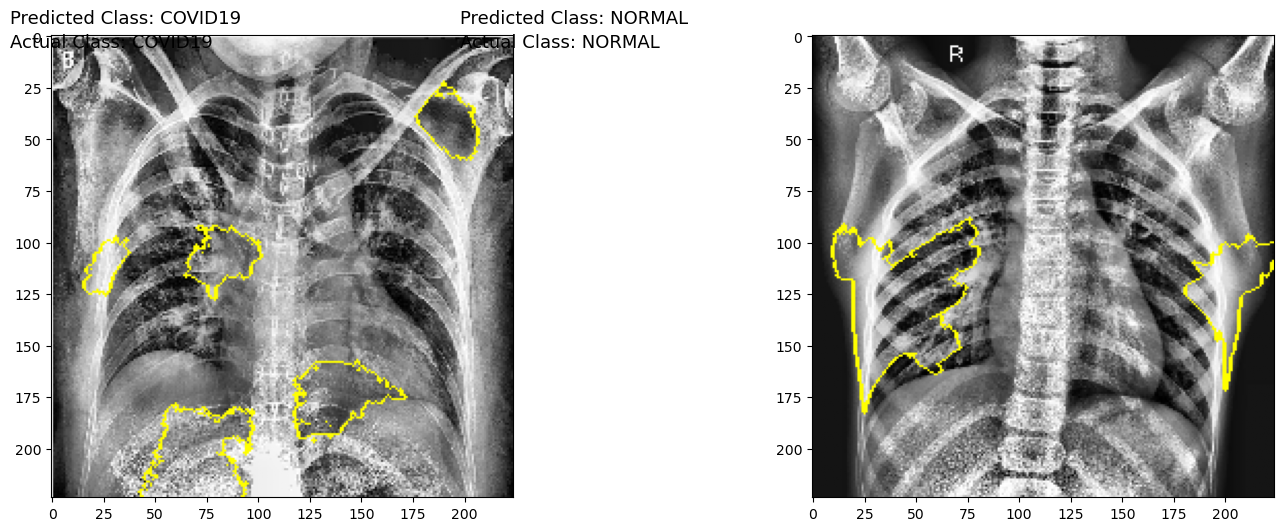

In [18]:
fig,ax = plt.subplots(1,2,figsize=(18,6))
visualize('test/COVID19/enhanced_COVID19(538).jpg',ax[0],0.15)
visualize('test/NORMAL/enhanced_NORMAL(1430).jpg',ax[1],0.4)